#RBM

In [ ]:
!pip install qiskit ipywidgets

In [2]:
from qiskit import *
from numpy import pi
import numpy as np
import math

#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

Generic class for qiskit circuit

In [3]:
class qCirc():
  def __init__(self, _circ, _nqbits, _print = False):
    self.__nqbits = _nqbits
    self.__circ = _circ
    if (_print ):
      print(_circ)

  def measure(self):
    for ind in range (0, self.__nqbits):
      self.__circ.measure(ind, ind)

  def get_datasource(self, nshots):
    backend_sim = Aer.get_backend('qasm_simulator')
    self.measure()
    job_sim = execute(self.__circ, backend_sim, shots = nshots, memory=True)
    result_sim = job_sim.result()
    data =  result_sim.get_memory()
  
    #counts = result_sim.get_counts(self.__circuit)
    #print(counts)
    list_ = []
    for num in data:
      list_.append([int(numeric_string) for numeric_string in list(num)])
    return  tf.convert_to_tensor(list_,tf.float32)
    

#W State with 'n' qubits

In [4]:
class qWn(qCirc):
  # Define a F_gate
  def __F_gate(self,circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
  def __init__(self, nqbits = 5, _print = False):
    qreg_q = QuantumRegister(nqbits, 'q')
    creg_c = ClassicalRegister(nqbits, 'c')
    circ = QuantumCircuit(qreg_q, creg_c)
    circ.x(qreg_q[nqbits-1]) #start is |10000>
    for i in range(nqbits):
      if (i+1 < nqbits):
        self.__F_gate(circ, qreg_q, nqbits-1-i, nqbits-2-i, nqbits, i+1)
    for i in range(nqbits):
      if (i+1 < nqbits):
        circ.cx(qreg_q[nqbits-2-i],qreg_q[nqbits-1-i])
    super().__init__(circ, nqbits, _print)

In [5]:
# Test qW20 with qWn
qw20 = qWn(20, False)
data_qw20 = qw20.get_datasource(10)
print( data_qw20)

tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(10, 20), dtype=float32)


## RBM Class

In [69]:
import random
class RBM:
  def __init__(self, visualUnits, hiddenUnits, alpha = 0.1 ):
    self.epoch_div = 10
    self.__hiddenUnits = hiddenUnits
    self.__visualUnits = visualUnits
    self.__alpha = alpha
    self.__reset_params()

  def __reset_params(self):
    self.__vb = tf.Variable(tf.zeros([self.__visualUnits]), tf.float32)              # Visual Layer bias
    self.__hb = tf.Variable(tf.zeros([self.__hiddenUnits]), tf.float32)               # Hidden Layer bias
    self.__W  = tf.Variable(tf.zeros([self.__visualUnits, self.__hiddenUnits]), tf.float32) # Weight matrix
  
  def get_vb( self ):
    return self.__vb
  def put_vb(self, vb):
    self.__vb = vb
  def get_hb( self ):
    return self.__hb
  def put_hb( self, hb):
    self.__hb = hb
  def get_W( self ):
    return self.__W
  def put_W(self, w):
    self.__W = w

  def get_sigma_tests( self, n , ntrips = 10):
    list = []
    qbits_number = self.__visualUnits
  
    for index in range(n):
      random_list = [random.randint(0, 1) for _ in range(qbits_number)]
      visual_0 = tf.convert_to_tensor(random_list,tf.float32)

      for ii in range (ntrips):   
        hidden_0 = self.make_hidden_layer(visual_0)
        visual_1 = self.remake_visual_layer(hidden_0)
        visual_0 = visual_1
      
      list.append(visual_1.numpy().tolist())
    
    return list

  def make_hidden_layer(self, visual_state):
    hidden_proba = tf.nn.sigmoid(tf.matmul([visual_state], self.__W) + self.__hb)  # probabilities of the hidden units
    hidden_state = tf.nn.relu(tf.sign(hidden_proba - tf.random.uniform(tf.shape(hidden_proba)))) # sample_h_given_X
    return hidden_state[0]

  def remake_visual_layer(self, hidden_state_source ):
    visual_proba = tf.nn.sigmoid(tf.matmul([hidden_state_source], tf.transpose(self.__W)) + self.__vb) 
    visual_state = tf.nn.relu(tf.sign(visual_proba - tf.random.uniform(tf.shape(visual_proba)))) #sample_v_given_h
    return visual_state[0]
   
  def error(self,v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

  def train(self, data_set, epochs = 100, every_epochs = 50, show = False):
    every_epochs = epochs / self.epoch_div
    self.__reset_params()
    by_epochs = []
    ind_epoch  = 0
    step = 0
    for epoch in range(1, epochs + 1):
      ind_epoch += 1
      for item in data_set: # cada item es del tipo [1.,0.,0.]
        visual_0 = item
        hidden_0 = self.make_hidden_layer(visual_0)
        visual_1 = self.remake_visual_layer(hidden_0)
        hidden_1 = self.make_hidden_layer(visual_1)
        delta_W = tf.matmul(tf.transpose([visual_0]), [hidden_0]) - tf.matmul(tf.transpose([visual_1]), [hidden_1])
        # los valores de los elementos de delta_w pueden ser sólo -1, 0 , 1
        self.__W = self.__W + self.__alpha * delta_W
        self.__vb = self.__vb + self.__alpha * tf.reduce_mean(visual_0 - visual_1, 0)
        self.__hb = self.__hb + self.__alpha * tf.reduce_mean(hidden_0 - hidden_1, 0) 
        step += 1
      if (ind_epoch >= every_epochs):
        ind_epoch = 0
        data = [epoch, step, self.__vb, self.__hb,self.__W]
        by_epochs.append(data)
        if show:
          print ("   >> training >> epoch = " + str(epoch))
    return by_epochs

  def check(self,data):
    nerr = 0
    count_err = 0
    for item in data:
      check_visual_0 = item
      check_hidden_0 = self.make_hidden_layer(check_visual_0)
      check_visual_1 = self.remake_visual_layer(check_hidden_0)
      err = tf.reduce_mean(tf.abs(check_visual_1 - check_visual_0), 0) 
      nerr = nerr + err
      if (err != 0):
        count_err += 1
        print(check_visual_0)
        print(check_visual_1)
        print('-------------------')
    nerr = nerr / len(data) 
    tf.print(nerr)
    print (str(count_err) + " errors of " + str(len(data)))

#Overlap

In [7]:
class Overlap:

  def _sumList(self, numList):
    result = 0
    for i in numList:
      result += i
    return result
    
  def _calculate_probability_distribution(self, sigmas, vb, hb, w):
    e = math.e
    n_visual_layer = len(vb)
    n_hidden_layer = len(hb)
    probabilities = [] #P_k(sigma)
    for sigma in sigmas: 
      sum_bsig = 0
      for v in range(n_visual_layer):
        sum_bsig += vb[v] * sigma[v]

      sum_log = 0
      for i in range(n_hidden_layer): 
        sum_wij = 0
        for j in range(n_visual_layer):
          sum_wij += w[j][i] * sigma[j]
        sum_log += math.log(1 + pow(e, hb[i] + sum_wij))

      probabilities.append(pow(e, sum_bsig + sum_log))

    return probabilities


  # calculate overlap between `state wave function`(psi_w) and the `RBM wave function`
  def _calculate_overlap(self, sigmas_ok, sigmas_all, b, c, w, psi_w, print_prob = False):
    probability_distributions_ok = self._calculate_probability_distribution(sigmas_ok, b, c, w) #P_lambda(sigma)
    probability_distributions_all = self._calculate_probability_distribution(sigmas_all, b, c, w) #P_lambda(sigma)

    Z = self._sumList(probability_distributions_all) #Z
    if (print_prob):
      tf.print("> Overlap Class > Probability Distribution = " , probability_distributions_ok)
      tf.print("> Overlap Class > sum Z = ", Z)
      probnor = probability_distributions_ok / Z
      tf.print("> Overlap Class > Probability Distr. norm. = " , probnor)
    psi_lambda_results = []
    mult_results = []
    for p in probability_distributions_ok:
        psi_lamda = math.sqrt(p/Z) #RBM wave-function
        #mult_results.append(psi_w * psi_lamda)
        mult_results.append(psi_w * psi_lamda)
    o = self._sumList(mult_results)
    return o

  def _intersection(self, lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

  def _estimate_overlap(self, sigmas_ok, sigmas_test, b, c, w):
    probability_distributions = self._calculate_probability_distribution(sigmas_ok, b, c, w) #P_lambda(sigma)
    sigmas_intersection = self._intersection(sigmas_test, sigmas_ok)
    probability_distributions_intersection = self._calculate_probability_distribution(sigmas_intersection, b, c, w)
    sum1 = 0
    sum3 = 0
    N = len(sigmas_ok)
    n = len(sigmas_test)
    n_intersection = len(sigmas_intersection)

    print('n', n, 'N', N, 'sigmas_intersection', len(sigmas_intersection))
    k = 1/math.sqrt(N)
  
    for pj in probability_distributions_intersection:
      sum1 = sum1 + ((1/math.sqrt(pj))*k)
    #1/√N   correcto??
    for pk in probability_distributions:
      sum3 = sum3 + math.sqrt(pk/N)
    tf.print("sum1 = ", sum1)
    tf.print("sum3 = ", sum3)
    return ((1/n)*sum1)*sum3  


In [26]:
class Overlap_Wn(Overlap):
  def __init__(self, rbm: RBM, generateAllSigmas = False):
    self.__rbm = rbm
    self.__vb = rbm.get_vb()
    self.__hb = rbm.get_hb()
    self.__w = rbm.get_W()
    self.__sigmas_ok = self._get_sigmas_ok(self.__vb)
    if generateAllSigmas:
      self.__sigmas_all = self._get_sigmas_all( self.__vb )
    self.__psi_w = 1/math.sqrt(len(self.__sigmas_ok)) #w-state wave-function  número de qubits

  def get_overlap(self, print_prob_distribution = False, b = 0, c = 0, w = 0 ):
    if len(b) == 0:
      b = self.__vb
    if len(c) == 0:
      c = self.__hb
    if len(w) == 0:
      w = self.__w
    return self._calculate_overlap(sigmas_ok = self.__sigmas_ok, sigmas_all = self.__sigmas_all, b = b, c = b, w = w, psi_w = self.__psi_w, print_prob =  print_prob_distribution)
  
  def estimate_overlap(self, sigmas_test, b = 0, c = 0, w = 0):
    if len(b) == 0:
      b = self.__vb
    if len(c) == 0:
      c = self.__hb
    if len(w) == 0:
      w = self.__w
    return self._estimate_overlap(sigmas_ok = self.__sigmas_ok, sigmas_test = sigmas_test, b = b, c = c, w = w)
   
  def _get_sigmas_all(self, size):
    initial_array = [0] * size
    final_list = self._generate_list(initial_array, [])
    return final_list

  def _get_sigmas_ok(self, size):
    final_list = []
    for i in range(size):
        array = [0] * size
        array[i] = 1
        final_list.append(array)
    return final_list

  def _sumList(self, numList):
    result = 0
    for i in numList:
      result += i
    return result

  def _sum_1(self, array):
    reversed_array = array[::-1]
    for i, num in list(enumerate(reversed_array)):
      if num == 0:
        reversed_array[i] = 1
        break
      else:
        reversed_array[i] = 0
    return reversed_array[::-1]
  def _generate_list(self, array, final_list):
    final_list.append(array)
    array = self._sum_1(array)
    if np.any(array):
      self._generate_list(array, final_list)
    return final_list



## Persist class

In [22]:
import json
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
class Persist:
  def __init__(self, v, h, alpha, nset, epochs_total, epochs_div = 10):
    self.__v = v
    self.__h = h
    self.__alpha = alpha
    self.__nset = nset
    self.__epochs_div = epochs_div
    self.__epochs_total = epochs_total
    self.__dir = 'drive/MyDrive/rbm/'
    self.__filenameRBM = str('{:02}'.format(v)) + "v" \
                    + str('{:02}'.format(h)) + "h" \
                    + str('{:02}'.format(int(alpha*100))) + "a" \
                    + str('{:05}'.format(nset)) + "nset" \
                    + str('{:03}'.format(epochs_total)) + "tepo" 
    print("filename_RBM = ", self.__filenameRBM)
    self.__filename = 'acum_data'
    self.__filenameRBM = self.__dir + self.__filenameRBM
    self.__filename = self.__dir + self.__filename 
  def append(self, step, overlap):
    file = open(self.__filename, "a", encoding="utf-8")
    data = [self.__v, self.__h, self.__alpha, self.__nset, self.__epochs_total, step, overlap]
    js = json.dumps(data)
    print(js, file = file)
    file.close()
  def read(self):
    file = open(self.__filename, "r", encoding="utf-8")
    lines = file.readlines()
    file.close()
    all_data = []
      
    for line in lines:
      if len(line) > 0:
        data = json.loads (line)
        if (data[0] == self.__v and
            data[1] == self.__h and 
            data[2] == self.__alpha and 
            data[3] == self.__nset  and
            data[4] == self.__epochs_total ) :
          all_data.append(data)

    return all_data

  def write_RBM(self, step, vb, hb, w):
    filenameRBM = self.__filenameRBM + str('{:05}'.format(step))
    file = open(filenameRBM, "w", encoding="utf-8")
    data = [self.__v, self.__h, self.__alpha, self.__nset, self.__epochs_total, step, vb, hb, w]
    js = json.dumps(data)
    file.write(js)
    file.close()
  def trunc(self):
    open(self.__filename, 'w').close()
  def trunc_RBM(self):
    open(self.__filenameRBM, 'w').close()
  def read_RBM(self, step):
    filenameRBM = self.__filenameRBM + str('{:05}'.format(step))
    file = open(filenameRBM, "r", encoding="utf-8")
    js = file.read()
    file.close()
    print('js=' , js)
    data = json.loads(js)
    rbm = RBM(visualUnits = data[0], hiddenUnits = data[1], alpha = data[2])
    rbm.put_vb(vb = data[6])
    rbm.put_hb(hb = data[7])
    rbm.put_W(w  = data[8])
    return rbm
'''    
persist = Persist( v = 5, h = 5, alpha = 0.4, nset = 200, epochs = 20 )
persist.append(30)
print(persist.read())
#persist.trunc()
'''


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'    \npersist = Persist( v = 5, h = 5, alpha = 0.4, nset = 200, epochs = 20 )\npersist.append(30)\nprint(persist.read())\n#persist.trunc()\n'

# Training

In [51]:
class TestWn:
  def __init__(self,n_visuallayer = 5, n_hiddenlayer = 5, alpha = 0.5, n_epochs = 10, n_data_source = 200 ):
    self.__rbm = RBM(n_visuallayer, n_hiddenlayer ,alpha = alpha )
    qwn = qWn(n_visuallayer, False)
    self.__data = qwn.get_datasource(n_data_source)
    self.__max_epoch = n_epochs
  def train(self):
    print("training rbm with epochs = ", self.__max_epoch)
    by_epoch = self.__rbm.train( data_set = self.__data, epochs = self.__max_epoch)
    print("rbm trained ")
    return by_epoch

  def get_overlap(self, b, c, w):
    Ovl = Overlap_Wn( self.__rbm)
    
    return Ovl.get_overlap( print_prob_distribution = True, b = b, c = c, w = w )

  def cal_overlap(self, b,c,w, n = 1000):
    Ovl = Overlap_Wn( self.__rbm )
    return Ovl.cal_overlap( sigmas_test = self.__rbm.get_sigma_tests(n) , b = b, c = c, w = w )

  def gibb( self, n = 100):
    return self.__rbm.get_sigma_tests( n )
  
  def good_gibb( self, n = 100 ):
   return self._filter_sigmas( self.gibb( n ))

  def _filter_sigmas( self, sigmas_tests):
    good_sigmas = []
    for s in sigmas_tests:
      if sum(s) == 1:
        good_sigmas.append(s.index(1) + 1)
    return good_sigmas

  def saveRBM(self):
    persist = Persist( v = self.__rbm.get_v)
    def __init__(self, v, h, alpha, nset, epochs_total, epochs_div = 10):


#train one RBM

In [ ]:
alpha = 0.5
n_epochs = 10
testN200 = TestWn( 20, 20, alpha = alpha, n_epochs = n_epochs , n_data_source = 200 )
testN200.train()

testN500 = TestWn( 20, 20, alpha = alpha, n_epochs = n_epochs , n_data_source = 500 )
testN500.train()
testN1000 = TestWn( 20, 20, alpha = alpha, n_epochs = n_epochs , n_data_source = 1000 )
testN1000.train()
testN2000 = TestWn( 20, 20, alpha = alpha, n_epochs = n_epochs , n_data_source = 2000 )
testN2000.train()
testN20000 = TestWn( 20, 20, alpha = alpha, n_epochs = n_epochs , n_data_source = 20000 )
testN20000.train()

In [ ]:
class Plot:
  def __init__(self, sigmas):
    self.__sigmas = sigmas
  def show(self):
    length = len(self.__sigmas)
    unique, rev = np.unique(self.__sigmas, return_inverse=True)
    np.bincount(rev)
    X = np.column_stack((unique,np.bincount(rev)/length))

    plt.bar(x=X[:, 0], height=X[:, 1])
    plt.xticks(unique)
    plt.yticks(np.arange(0, 0.2, step=0.02))
    plt.show()    

plotN200 = Plot( testN200.good_gibb(1000) )
plotN200.show()

plotN500 = Plot( testN500.good_gibb(1000) )
plotN500.show()

plotN1000 = Plot( testN1000.good_gibb(1000) )
plotN1000.show()

plotN2000 = Plot( testN2000.good_gibb(1000) )
plotN2000.show()

plotN20000 = Plot( testN2000.good_gibb(1000) )
plotN20000.show()

training rbm with epochs =  10
rbm trained 


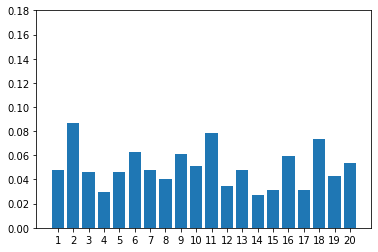

In [70]:
test = TestWn( 20, 20, alpha = 0.1, n_epochs = 10 , n_data_source = 20000 )
test.train()
plot = Plot(test.good_gibb(1000))
plot.show()


#multi train

In [16]:
# 
n_visual = 7
n_hidden = 5
array_alpha = [0.1, 0.3, 0.5, 0.7, 0.9]
array_n_data_set = [50,100,200,500,1000]
array_n_data_set = [100]
n_epochs_max = 100
do_persist = False

for n_data_set in array_n_data_set:
  for alpha in array_alpha:
    if do_persist:
      persist = Persist(v = n_visual , h = n_hidden, alpha = alpha, nset = n_data_set , epochs_total = n_epochs_max ) 
    x = []
    y = []

    test = TestWn( n_visuallayer = n_visual, n_hiddenlayer = n_hidden, alpha = alpha, n_epochs = n_epochs_max, n_data_source = n_data_set )
    by_epoch = test.train()
    min = 1
    for epo in by_epoch:
    #data = [epoch, step, self.__vb, self.__hb,self.__W]
      epoch_num = epo[0]
      step = epo[1]
      vb = epo[2]
      hb = epo[3]
      w  = epo[4]
      epoch_num_str = str(epoch_num)
      vb_str = vb.numpy().tolist()
      hb_str = hb.numpy().tolist()
      w_str  = w.numpy().tolist()

      print('calculating overlap of epoch = ' + epoch_num_str)
      over_value = test.get_overlap( b = vb, c = hb, w = w)
      print("overlap = ", over_value)
      if do_persist:
        persist.append(step = step, overlap = over_value)
        persist.write_RBM(step = step, vb = vb_str, hb = hb_str, w = w_str )
      
      x.append(epo[0])
      y.append(over_value)
      if (over_value < min) :
        min = over_value

  if (min > 0.8):
    min = 0.8
  plt.ylim(min,1)
  xi = list(range(len(x)))
  plt.xticks(xi, x)
  plt.plot(x,y,marker='o')
  plt.show()

training rbm with epochs =  100
   >> training >> epoch = 10
   >> training >> epoch = 20
   >> training >> epoch = 30
   >> training >> epoch = 40
   >> training >> epoch = 50
   >> training >> epoch = 60
   >> training >> epoch = 70
   >> training >> epoch = 80
   >> training >> epoch = 90
   >> training >> epoch = 100
rbm trained 
calculating overlap of epoch = 10


AttributeError: ignored

#multi read (different alphas)

In [ ]:
 read_nvis = 5
 read_hidden = 5
 read_n_data_set = 5000
 read_n_epochs = 10
 
 x = []
 y = []
 min = 1
 max = 0

 read_alpha_array = [0.1, 0.3, 0.5, 0.7, 0.9]
 count = 0
 for read_alpha in read_alpha_array:
   y.append([])

   read_persist = Persist(v = read_nvis , h = read_hidden, alpha = read_alpha, nset = read_n_data_set , epochs_total = read_n_epochs   )
   read_data = read_persist.read()

   for data in read_data:
     print (data)
     if (count == 0):
       x.append(data[5])  
     y[count].append(data[6])
     if data[6] > max:
       max = data[6]
     if (min > data[6]) :
       min = data[6]
   count += 1


 if (min > 0.8):
   min = 0.8
 plt.ylim(min,1)
 greek_letterz=[chr(code) for code in range(945,970)]
 plt.plot(x,y[0], marker='o', label = greek_letterz[0] + ' = 0.1', color=(0,0,0 ))
 plt.plot(x,y[1], marker='o', label = greek_letterz[0] + ' = 0.3', color=(0,0,1 ), linestyle='--')
 plt.plot(x,y[2], marker='o', label = greek_letterz[0] + ' = 0.5', color=(1,0,0 ))
 plt.plot(x,y[3], marker='o', label = greek_letterz[0] + ' = 0.7', color=(0,1,1 ),linestyle='--')
 plt.plot(x,y[4], marker='o', label = greek_letterz[0] + ' = 0.9', color=( 0.8,0.8,0.8))
 plt.legend(loc='lower right')
 plt.title('N = ' + str(read_n_data_set )  + ' hidden = ' + str(read_hidden) + ' epochs =' + str(read_n_epochs) + ' Max =' + str('{:.4f}'.format(max)) )

 plt.show()  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# find maximum overlap

def mySort(data):
  return data[6]

file = open( 'drive/MyDrive/rbm/acum_data', "r", encoding="utf-8")
  lines = file.readlines()
  file.close()
  all_data = []
      
  for line in lines:
    if len(line) > 0:
      data = json.loads (line)
      all_data.append(data)
    
  all_data.sort(key=mySort)

#gibb sampling

#Training without overlap

In [ ]:

n_visual = 20
n_hidden = 5
array_alpha = [0.1, 0.3, 0.5, 0.7, 0.9]
array_alpha = [0.1]
array_n_data_set = [100]
n_epochs_max = 10

for n_data_set in array_n_data_set:
  for alpha in array_alpha:
    persist = Persist(v = n_visual , h = n_hidden, alpha = alpha, nset = n_data_set , epochs_total = n_epochs_max ) 
    x = []
    y = []

    test = TestWn(n_visuallayer = n_visual, n_hiddenlayer = n_hidden, alpha = alpha, n_epochs = n_epochs_max, n_data_source = n_data_set )
    by_epoch = test.train()
    min = 1
    for epo in by_epoch:
    #data = [epoch, step, self.__vb, self.__hb,self.__W]
      epoch_num = epo[0]
      step = epo[1]
      vb = epo[2]
      hb = epo[3]
      w  = epo[4]
      epoch_num_str = str(epoch_num)
      vb_str = vb.numpy().tolist()
      hb_str = hb.numpy().tolist()
      w_str  = w.numpy().tolist()

      persist.write_RBM(step = step, vb = vb_str, hb = hb_str, w = w_str )
      


filename_RBM =  20v05h10a00100nset010tepo
training rbm with epochs =  10
   >> training >> epoch = 1
   >> training >> epoch = 2
   >> training >> epoch = 3
   >> training >> epoch = 4
   >> training >> epoch = 5
   >> training >> epoch = 6
   >> training >> epoch = 7
   >> training >> epoch = 8
   >> training >> epoch = 9
   >> training >> epoch = 10
rbm trained 


In [ ]:
over_buena10 = Overlap_Wn( rbm_w5_buena10 )

overlap_buena10 = over_buena10.get_overlap( True )
tf.print("Overlap = ", overlap_buena10)
estimation_buena10 = over_buena10.get_estimate_overlap(nsigmas = 1000, ntrips = 10)
tf.print("Estimation Overlap ^2 = ", estimation_buena10)
tf.print("Estimation Overlap =", math.sqrt(estimation_buena10))

NameError: ignored